## Imports

In [ ]:
from pybaseball import statcast, cache
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline

## Data Collection

In [ ]:
# Enable caching for pybaseball
cache.enable()

# Fetching Statcast data for the specified date range
df = statcast(start_dt = '2024-04-03', end_dt = '2024-07-03')
df.to_csv("cached_statcast.csv", index=False)

# Fetching pitcher data for the specified date range
df_pitcher = statcast(start_dt = '2023-04-01', end_dt = '2024-10-01')
df_pitcher.to_csv("cached_pitcher_statcast.csv", index=False)

This is a large query, it may take a moment to complete


  0%|          | 0/92 [00:00<?, ?it/s]/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passi

This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 430/430 [07:12<00:00,  1.01s/it]
/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


## Pre-Processing

In [3]:
# One of the ways you know a column is post pitch is if the data has a significant number of null values. For example, any "ball-strike" features will have a significant amount of nulls
pre_pitch_cols = ['game_date', 'player_name', 'batter', 'pitcher', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'game_pk', 'pitcher', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score', 'fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 'age_bat', 'age_bat_legacy', 'age_pit', 'age_pit_legacy', 'arm_angle', 'bat_score_diff', 'bat_win_exp', 'batter_days_since_prev_game', 'batter_days_until_next_game', 'home_score_diff', 'home_win_exp', 'n_priorpa_thisgame_player_at_bat', 'n_thruorder_pitcher', 'pitcher_days_since_prev_game', 'pitcher_days_until_next_game']
post_pitch_cols = ['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'events', 'description', 'zone', 'des', 'type', 'hit_location', 'bb_type', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'hc_x', 'hc_y', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'launch_speed', 'launch_angle', 'effective_speed', 'release_extension', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'post_home_score', 'post_away_score', 'post_bat_score', 'spin_axis', 'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp', 'estimated_slg_using_speedangle', 'hit_distance_sc', 'intercept_ball_minus_batter_pos_x_inches', 'intercept_ball_minus_batter_pos_y_inches', 'post_fld_score', 'api_break_x_arm', 'api_break_x_batter_in', 'api_break_z_with_gravity', 'attack_angle', 'attack_direction', 'bat_speed', 'release_spin_rate', 'spin_dir', 'swing_length', 'swing_path_tilt']
deprecated_cols = ['break_angle_deprecated', 'break_length_deprecated', 'hyper_speed', 'spin_rate_deprecated', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire']
known_columns = set(pre_pitch_cols) | set(post_pitch_cols) | set(deprecated_cols)
# congigured id columns
ID_columns = ['batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'fielder_2', 'sv_id', 'game_pk', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9']
print(len(known_columns))
print(df.shape)

pre_pitch_data = df[pre_pitch_cols]
print(pre_pitch_data.shape)

nan_counts = pre_pitch_data.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
nan_counts = nan_counts[nan_counts < pre_pitch_data.shape[0]]

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Non-NaN Count': pre_pitch_data.shape[0] - nan_counts,
    'Percent Missing': nan_counts / pre_pitch_data.shape[0] 
})
display(nan_summary)


118
(352570, 118)
(352570, 51)


,NaN Count,Non-NaN Count,Percent Missing
on_3b,319999,32571,0.907618
on_2b,286465,66105,0.812505
on_1b,246477,106093,0.699087
if_fielding_alignment,2182,350388,0.006189
of_fielding_alignment,2182,350388,0.006189
arm_angle,1931,350639,0.005477
batter_days_since_prev_game,1967,350603,0.005579
batter_days_until_next_game,722,351848,0.002048
pitcher_days_since_prev_game,11926,340644,0.033826
pitcher_days_until_next_game,4402,348168,0.012485


In [4]:
# pull pitcher pitch distributions
# Filter columns you need
cols = ['pitcher', 'pitch_type', 'game_pk', 'release_spin_rate']
pitch_data = df_pitcher[cols]

# Pitch type distribution
pitch_type_dist = (
    pitch_data.groupby(['pitcher', 'pitch_type'])
    .size()
    .reset_index(name='pitch_count')
)

# Calculate total pitches per pitcher
total_pitches = (
    pitch_data.groupby('pitcher')
    .size()
    .reset_index(name='total_pitches')
)

# Merge and calculate proportion
pitch_type_dist = pitch_type_dist.merge(total_pitches, on='pitcher')
pitch_type_dist['pitch_type_pct'] = pitch_type_dist['pitch_count'] / pitch_type_dist['total_pitches']

# Pivot to wide format
pitch_agg = pitch_type_dist.pivot_table(
    index='pitcher',
    columns='pitch_type',
    values='pitch_type_pct',
    fill_value=0
).reset_index()
pitch_agg.columns = ['pitcher'] + [f'pitch_pct_{c}' for c in pitch_agg.columns if c != 'pitcher']
print(pitch_agg.head())

   pitcher  pitch_pct_CH  pitch_pct_CS  pitch_pct_CU  pitch_pct_EP  \
0   425794      0.049860      0.001681      0.305882           0.0   
1   425844      0.166433      0.000468      0.135577           0.0   
2   434378      0.065949      0.000000      0.205249           0.0   
3   445276      0.000000      0.000000      0.000000           0.0   
4   445926      0.133901      0.000000      0.065733           0.0   

   pitch_pct_FA  pitch_pct_FC  pitch_pct_FF  pitch_pct_FO  pitch_pct_FS  \
0           0.0      0.226331      0.099720           0.0           0.0   
1           0.0      0.068724      0.273960           0.0           0.0   
2           0.0      0.000000      0.495289           0.0           0.0   
3           0.0      0.797297      0.000000           0.0           0.0   
4           0.0      0.505173      0.000609           0.0           0.0   

   pitch_pct_KC  pitch_pct_KN  pitch_pct_PO  pitch_pct_SC  pitch_pct_SI  \
0           0.0           0.0      0.000000          

In [5]:
# pull historical batter data
cols = ['batter', 'pitch_type', 'game_pk']
batter_data = df_pitcher[cols]

# Pitch type distribution by batter
batter_pitch_type_dist = (
    batter_data.groupby(['batter', 'pitch_type'])
    .size()
    .reset_index(name='pitch_count')
)

# Total pitches faced
total_pitches_faced = (
    batter_data.groupby('batter')
    .size()
    .reset_index(name='total_pitches_faced')
)

batter_pitch_type_dist = batter_pitch_type_dist.merge(total_pitches_faced, on='batter')
batter_pitch_type_dist['pitch_type_pct'] = batter_pitch_type_dist['pitch_count'] / batter_pitch_type_dist['total_pitches_faced']

# Pivot wide
batter_agg = batter_pitch_type_dist.pivot_table(
    index='batter',
    columns='pitch_type',
    values='pitch_type_pct',
    fill_value=0
).reset_index()

batter_agg.columns = ['batter'] + [f'batter_pct_{c}' for c in batter_agg.columns if c != 'batter']
print(batter_agg.head())

   batter  batter_pct_CH  batter_pct_CS  batter_pct_CU  batter_pct_EP  \
0  408234       0.075073            0.0       0.044461       0.000000   
1  425794       0.000000            0.0       0.000000       0.000000   
2  443558       0.146209            0.0       0.045126       0.000000   
3  444482       0.135956            0.0       0.076743       0.000779   
4  444489       0.170213            0.0       0.042553       0.000000   

   batter_pct_FA  batter_pct_FC  batter_pct_FF  batter_pct_FO  batter_pct_FS  \
0       0.000000       0.075802       0.370991            0.0       0.004373   
1       0.000000       0.142857       0.857143            0.0       0.000000   
2       0.000000       0.088448       0.310469            0.0       0.016245   
3       0.002727       0.095442       0.322945            0.0       0.032723   
4       0.000000       0.191489       0.234043            0.0       0.000000   

   batter_pct_KC  batter_pct_KN  batter_pct_PO  batter_pct_SC  batter_pct_SI  \


In [ ]:
# Since 'on_1b', 'on_2b', and 'on_3b' are all player ID's for players on those bases, I made these additional binary columns as it would still be valuable to know if there are players on base. 
df.loc[:, 'runner_on_1b'] = df['on_1b'].notnull().astype(int)
df.loc[:, 'runner_on_2b'] = df['on_2b'].notnull().astype(int)
df.loc[:, 'runner_on_3b'] = df['on_3b'].notnull().astype(int)

cols_to_drop_na = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'arm_angle',
    'batter_days_since_prev_game',
    'batter_days_until_next_game',
    'pitcher_days_since_prev_game',
    'pitcher_days_until_next_game'
]

# Drop the rows with null values in the columns included in 'cols_to_drop_na'
df_clean = df.dropna(subset=cols_to_drop_na)
df_clean = df_clean.reset_index(drop=True)

# How many rows were dropped and what is the percentage of the total amount of rows?
rows_dropped = len(df) - len(df_clean)
percent_dropped = rows_dropped / len(df)
print(rows_dropped)
print(percent_dropped)


20347
0.05771052556939048


In [7]:
non_numeric_columns = pre_pitch_data.select_dtypes(include=['object']).columns
display(df[non_numeric_columns].head(2))
# We could potentially change the player_name to player_id. Problem is that some players will have way more pitches or at-bats than others. If we have time to comeback to it,
# then let's consider including aggregated data for each player (rolling batting average or ERA for last 10 games) or potentially removing pitches from pitchers/batters with
# less than a certain number of pitches/at-bats. Note that both batter and pitcher are unique ID. So we could easily include them. 
player_specific_cols = ['player_name', 'batter', 'pitcher']
# This is type of game: Regular season, spring training, wild card, division series, etc. Right now I only have regular season games, so let's drop this. 
game_type = df_clean['game_type'].value_counts()
# One hot encode. This is left or right handed batter
stand = df_clean['stand'].value_counts()
# One hot encode. This is left or right handed pitcher
p_throws = df_clean['p_throws'].value_counts()
# One hot encode
home_team = df_clean['home_team'].value_counts()
# One hot encode
away_team = df_clean['home_team'].value_counts()
# One hot encode. Categorizes top or bottom of the inning.
inning_topbot = df_clean['inning_topbot'].value_counts()
# One hot encode. Categorizes Standard, infield shade, and strategic alignment
if_fielding_alignment = df_clean['if_fielding_alignment'].value_counts()
# One hot encode. Categorizes Standard and strategic alignment
of_fielding_alignment = df_clean['of_fielding_alignment'].value_counts()
# We don't want to include game date in the regression. So let's add columns game_dayofweek, game_month, to the df
df_clean['game_dayofweek'] = df_clean['game_date'].dt.dayofweek
df_clean['game_month'] = df_clean['game_date'].dt.month
# join pitcher aggregated data
if 'pitch_pct_CH' not in list(df_clean.columns):
    df_clean = df_clean.merge(pitch_agg, left_on='pitcher', right_on='pitcher', how='left')

if 'batter_pct_CH' not in list(df_clean.columns):
    df_clean = df_clean.merge(batter_agg, left_on='batter', right_on='batter', how='left')

cols_to_drop = ['player_name', 'game_date', 'game_type', 'game_year']   # taking out game_year
all_cols_to_drop = cols_to_drop + post_pitch_cols + deprecated_cols + ID_columns

,player_name,game_type,stand,p_throws,home_team,away_team,inning_topbot,if_fielding_alignment,of_fielding_alignment
2714,"Iglesias, Raisel",R,L,R,ATL,SF,Top,Infield shade,Standard
2731,"Iglesias, Raisel",R,L,R,ATL,SF,Top,Infield shade,Standard


## EDA

   pitch_type       pitch_name   count
0          FF  4-Seam Fastball  104857
1          SI           Sinker   53060
2          SL           Slider   50894
3          CH         Changeup   33477
4          FC           Cutter   27663
5          ST          Sweeper   22770
6          CU        Curveball   20886
7          FS     Split-Finger   10769
8          KC    Knuckle Curve    5734
9          SV           Slurve    1366
10         KN      Knuckleball     581
11         FO         Forkball      73
12         FA            Other      46
13         EP           Eephus      19
14         PO        Pitch Out      19
15         CS       Slow Curve       9


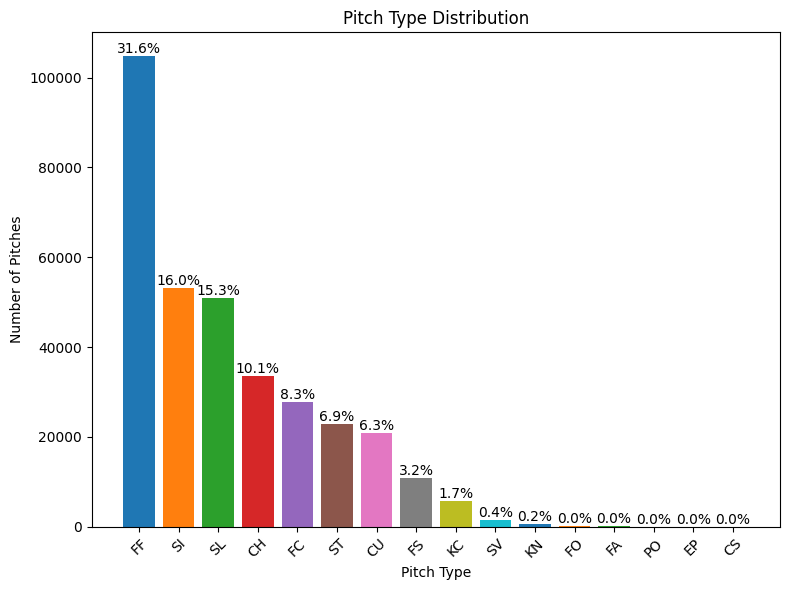

In [8]:
# pitch distribution
pitch_names = df_clean[['pitch_type', 'pitch_name']].value_counts().reset_index(name='count')
print(pitch_names)

# collect the pitch type distribution
pitch_counts = df_clean['pitch_type'].value_counts().sort_values(ascending=False)
pitch_types = pitch_counts.index
total_pitches = pitch_counts.sum()
# set up the colors
colors = sns.color_palette("tab10", n_colors=len(pitch_types)).as_hex()

# plot the pitch type
plt.figure(figsize=(8,6))
bars = plt.bar(pitch_types, pitch_counts.values, color = colors)
for bar, count in zip(bars, pitch_counts.values):
    height = bar.get_height()
    pct = 100 * count / total_pitches
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # center x
        height,                             # height y
        f'{pct:.1f}%',                      # text
        ha='center', va='bottom', fontsize=10
    )
plt.title('Pitch Type Distribution')
plt.xlabel('Pitch Type')
plt.ylabel('Number of Pitches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Should we get rid of the bottom four? FA (Other), PO (Pitch Out), EP (Eephus), CS (slow curve), KN (knuckle curve). It may be silly to analyze these as they are most likely thrown by players that aren't actual pitchers.

In [9]:
# filter out minimum pitch types
pitch_types_excluded = ['FO','PO','FA','EP','SV','KN','CS']
mask = ~df_clean['pitch_type'].isin(pitch_types_excluded)
df_clean = df_clean[mask]
print(df_clean['pitch_type'].unique())

['CH' 'FF' 'SL' 'SI' 'KC' 'FC' 'CU' 'ST' 'FS']


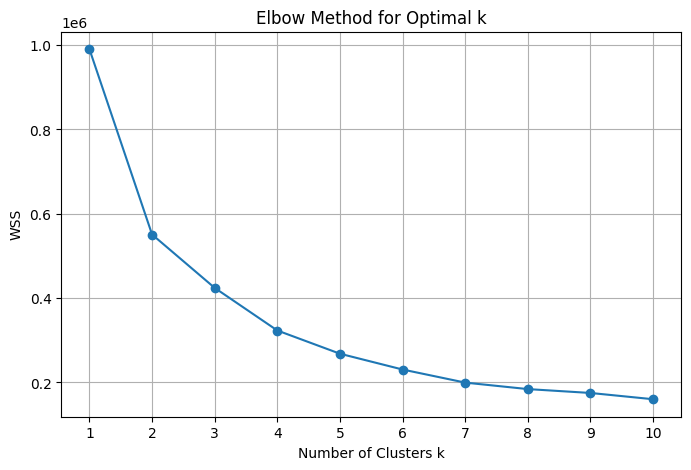

In [10]:
# run clustering on the pitch types
cluster_features = ['release_speed', 'pfx_x', 'pfx_z']
X_cluster = df_clean[cluster_features].dropna()
# scale the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)
# identify the optimal k value
wss=[]
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    wss.append(kmeans.inertia_)

# Plot elbow
plt.figure(figsize=(8, 5))
plt.plot(k_values, wss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters k')
plt.ylabel('WSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()


Optimal K looks to be around 4.

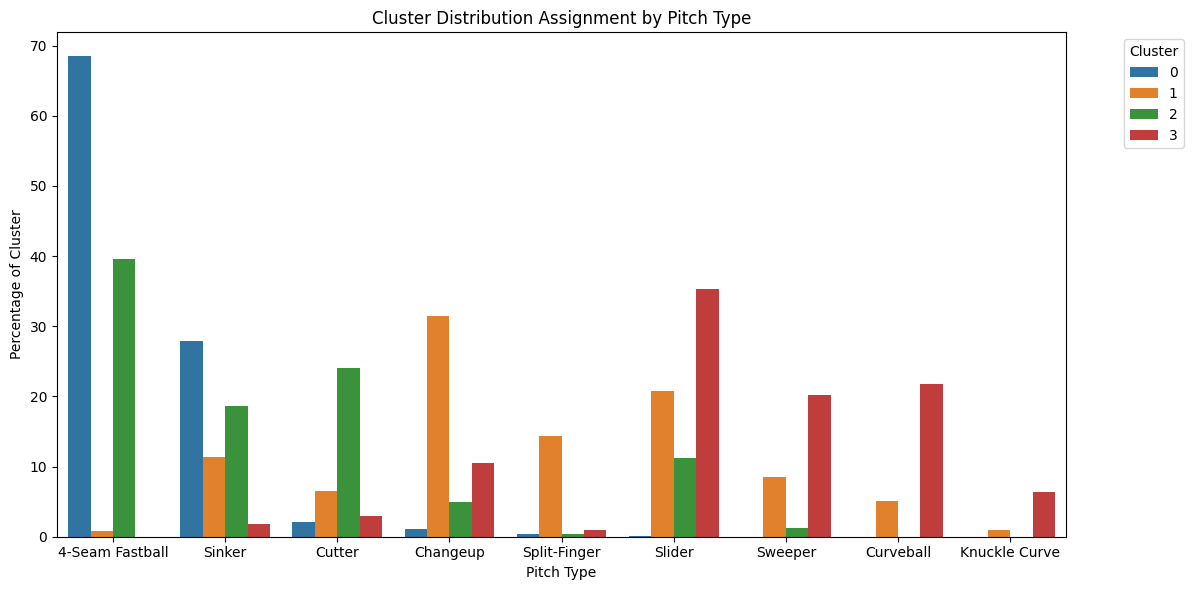

In [11]:
# run with optimal clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_clustered = df_clean.loc[X_cluster.index].copy()
df_clustered['cluster'] = clusters

pitch_cluster_map = (
    df_clustered.groupby(['cluster', 'pitch_type', 'pitch_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['cluster', 'count'], ascending=[True, False])
)

# pd.set_option('display.max_rows', None)
# print(pitch_cluster_map)

pitch_cluster_map['total'] = pitch_cluster_map.groupby('cluster')['count'].transform('sum')
pitch_cluster_map['pct'] = pitch_cluster_map['count'] / pitch_cluster_map['total'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(
    data=pitch_cluster_map,
    x='pitch_name',
    y='pct',
    hue='cluster',
    palette='tab10'
)
plt.title('Cluster Distribution Assignment by Pitch Type')
plt.xlabel('Pitch Type')
plt.ylabel('Percentage of Cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Based on cluster analysis we can see the distribution breakdown in terms of where they were assigned. Below is the rules we can use based off of this:
- 4 Seam Fastball: primarily assigned to cluster 0 and 2
- Sinker: primarily assigned to cluster 0 and 2
- Cutter: primarily assigned to cluster 1 and 2
- Changeup: primarily assigned to cluster 1 and 3
- Split Finger Pitch Type: primarily assigned to cluster 1 and 3
- Slider: primarily assigned to cluster 3 and 1
- Sweeper: primarily assigned to cluster 3 and 1
- Curveball: primarily assigned to cluster 3 and 1
- knuckle curve: primarily assigned to cluster 3 and 1

Based on these cluster distributions - we can create three categories:
1. Fastball: includes 4 Seam Fastball, Sinker, Cutter
2. Changeup: includes Changeup, Split-Finger Pitch
3. Off-speed: includes Slider, Sweeper, Curveball, Knuckle Curve

In [12]:
# based on the rules above, create new category for the reponse
fastball = ['FF','FC','SI']
changeup = ['CH','FS']
offspeed = ['CU','SL','KC','ST']

conditions = [
    df_clean['pitch_type'].isin(fastball),
    df_clean['pitch_type'].isin(changeup),
    df_clean['pitch_type'].isin(offspeed)
]
choices = ['fastball', 'changeup', 'offspeed']
df_clean['pitch_category'] = np.select(conditions, choices, default='Other')

print(df_clean['pitch_category'].unique())


['changeup' 'fastball' 'offspeed']


### Set up the final dataset for modeling

In [13]:
# set up y dataframe
y = df_clean['pitch_name']
y_category = df_clean['pitch_category']
print(y.shape)
print(df_clean.shape)

# set up X dataframe
X = df_clean.drop(columns=all_cols_to_drop)
X = X.drop(columns='pitch_category')
print(X.shape)
print(X.columns.tolist())

# create dummy variables
X_encoded = pd.get_dummies(X, drop_first=False)
print(X_encoded.shape)

# set up train and test sets
X_train, X_test, y_train, y_test, y_train_cat, y_test_cat = train_test_split(X_encoded, y, y_category, test_size=.25, shuffle=True, random_state=6740)
print(y.unique())

(330110,)
(330110, 158)
(330110, 71)
['stand', 'p_throws', 'home_team', 'away_team', 'balls', 'strikes', 'outs_when_up', 'inning', 'inning_topbot', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score', 'fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 'home_score_diff', 'bat_score_diff', 'home_win_exp', 'bat_win_exp', 'age_pit_legacy', 'age_bat_legacy', 'age_pit', 'age_bat', 'n_thruorder_pitcher', 'n_priorpa_thisgame_player_at_bat', 'pitcher_days_since_prev_game', 'batter_days_since_prev_game', 'pitcher_days_until_next_game', 'batter_days_until_next_game', 'arm_angle', 'runner_on_1b', 'runner_on_2b', 'runner_on_3b', 'game_dayofweek', 'game_month', 'pitch_pct_CH', 'pitch_pct_CS', 'pitch_pct_CU', 'pitch_pct_EP', 'pitch_pct_FA', 'pitch_pct_FC', 'pitch_pct_FF', 'pitch_pct_FO', 'pitch_pct_FS', 'pitch_pct_KC', 'pitch_pct_KN', 'pitch_pct_PO', 'pitch_pct_SC', 'pitch_pct_SI', 'pitch_pct_SL', 'pitch_pct_ST', 'pitch_pct_SV', 'batter_pct_CH', 'batter_pct_CS', 'batt

In [14]:
binary_cols = [col for col in X_encoded if X_encoded[col].nunique() == 2]
non_binary_cols = [col for col in X_encoded if col not in binary_cols]
discrete_vars = ['balls', 'strikes', 'outs_when_up', 'inning', 'game_dayofweek', 'game_month']
continuous_vars = [col for col in non_binary_cols if col not in discrete_vars]

scaler = StandardScaler()
# The reason I don't standardize X_encoded before splitting out the training and testing set's is because the set of variables in X_test might be different than in X_train.
# So, if I standardize X_encoded, the training and testing set might not have mean zero and standard deviation equal to one. 
X_train_standardized = X_train
X_test_standardized = X_test
X_train_standardized[non_binary_cols] = scaler.fit_transform(X_train_standardized[non_binary_cols])
X_test_standardized[non_binary_cols] = scaler.fit_transform(X_test_standardized[non_binary_cols])

## Run PCA

(247582, 42)


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


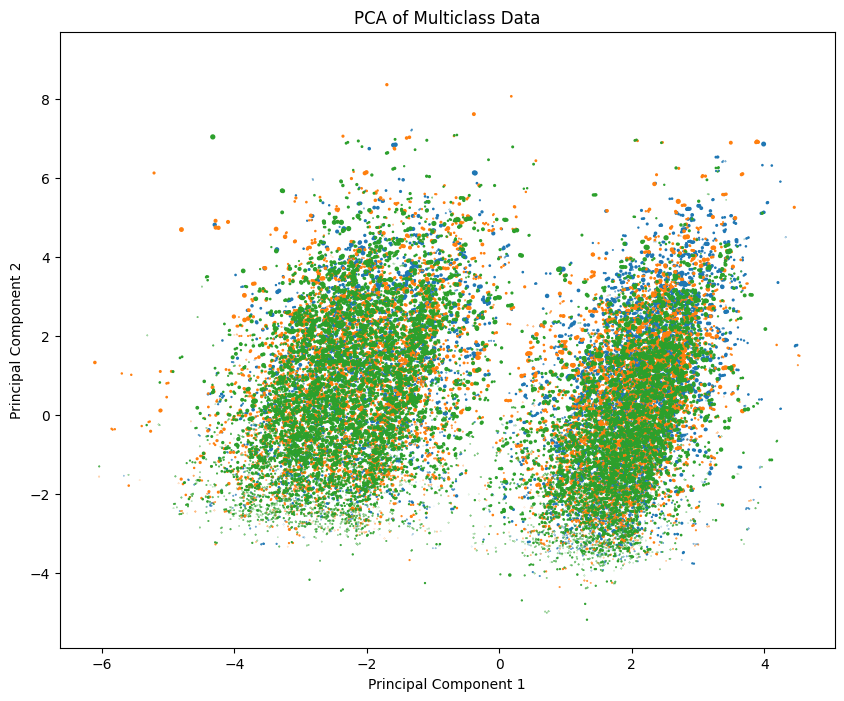

In [15]:
# run the PCA analysis
pca = PCA(n_components=.9)
X_train_pca = pca.fit_transform(X_train_standardized)
X_test_pca = pca.transform(X_test_standardized)
print(X_train_pca.shape)

# plot the first two components to see if there are any clear clusters
plt.figure(figsize=(10,8))
plt.scatter(X_train_pca[y_train == 'Sweeper',0], X_train_pca[y_train == 'Sweeper',1], X_train_pca[y_train == 'Sweeper',2], label='Sweeper')
plt.scatter(X_train_pca[y_train == 'Cutter',0], X_train_pca[y_train == 'Cutter',1], X_train_pca[y_train == 'Cutter',2], label='Cutter')
plt.scatter(X_train_pca[y_train == 'Changeup',0], X_train_pca[y_train == 'Changeup',1], X_train_pca[y_train == 'Changeup',2], label='Changeup')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Multiclass Data')
# plt.legend()
plt.show()

## Logistic Regression

Run a logistic regression model with an L1 penalty on the Pitch Type

In [27]:
# run the logistic regression lasso model
lr_cv = LogisticRegressionCV(Cs=[100, 500, 1000], cv=3, penalty='l1', solver='saga', multi_class='multinomial', max_iter=500, tol=1e-2, verbose=1)
lr_cv.fit(X_train_standardized, y_train)

/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Epoch 1, change: 1
Epoch 2, change: 0.28442798
Epoch 3, change: 0.15217126
Epoch 4, change: 0.10100992
Epoch 5, change: 0.072213786
Epoch 6, change: 0.056676469
Epoch 7, change: 0.045329204
Epoch 8, change: 0.037127635
Epoch 9, change: 0.031071781
Epoch 10, change: 0.026746254
Epoch 11, change: 0.023586341
Epoch 12, change: 0.021935249
Epoch 13, change: 0.020427662
Epoch 14, change: 0.019112512
Epoch 15, change: 0.017903566
Epoch 16, change: 0.016748592
Epoch 17, change: 0.015718817
Epoch 18, change: 0.014758465
Epoch 19, change: 0.013854914
Epoch 20, change: 0.012961108
Epoch 21, change: 0.012168697
Epoch 22, change: 0.011412834
Epoch 23, change: 0.010732126
Epoch 24, change: 0.010241901
Epoch 25, change: 0.010035946
convergence after 26 epochs took 31 seconds
Epoch 1, change: 1
convergence after 2 epochs took 2 seconds
Epoch 1, change: 1
convergence after 2 epochs took 2 seconds
Epoch 1, change: 1
Epoch 2, change: 0.28438771
Epoch 3, change: 0.15023811
Epoch 4, change: 0.099670681
Ep

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min finished


LogisticRegressionCV(Cs=[100, 500, 1000], cv=3, max_iter=500,
                     multi_class='multinomial', penalty='l1', solver='saga',
                     tol=0.01, verbose=1)

Run a logistic regression model with an L1 penalty on the Pitch Category

In [45]:

lr_cv_pitch_category = LogisticRegressionCV(Cs=[100, 500, 1000], cv=3, penalty='l1', solver='saga', multi_class='multinomial', max_iter=500, tol=1e-2, verbose=2)
lr_cv_pitch_category.fit(X_train_standardized, y_train_cat)

/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Epoch 1, change: 1
Epoch 2, change: 0.33041252
Epoch 3, change: 0.16382407
Epoch 4, change: 0.10179273
Epoch 5, change: 0.070038576
Epoch 6, change: 0.051710642
Epoch 7, change: 0.040335648
Epoch 8, change: 0.030973815
Epoch 9, change: 0.024817511
Epoch 10, change: 0.019936077
Epoch 11, change: 0.016269606
Epoch 12, change: 0.013349141
Epoch 13, change: 0.011068274
convergence after 14 epochs took 7 seconds
Epoch 1, change: 1
convergence after 2 epochs took 2 seconds
Epoch 1, change: 1
convergence after 2 epochs took 1 seconds
Epoch 1, change: 1
Epoch 2, change: 0.32443684
Epoch 3, change: 0.16417192
Epoch 4, change: 0.099846924
Epoch 5, change: 0.068595753
Epoch 6, change: 0.051512485
Epoch 7, change: 0.039082244
Epoch 8, change: 0.030563329
Epoch 9, change: 0.024060712
Epoch 10, change: 0.019782963
Epoch 11, change: 0.015914708
Epoch 12, change: 0.01309714
Epoch 13, change: 0.010887622
convergence after 14 epochs took 8 seconds
Epoch 1, change: 1
convergence after 2 epochs took 2 sec

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.5s finished


Epoch 1, change: 1
convergence after 2 epochs took 2 seconds


LogisticRegressionCV(Cs=[100, 500, 1000], cv=3, max_iter=500,
                     multi_class='multinomial', penalty='l1', solver='saga',
                     tol=0.01, verbose=2)

In [ ]:
joblib.dump(lr_cv, "logistic_model2.pkl")

['logistic_model_pitch_category.pkl']

In [43]:
joblib.dump(lr_cv_pitch_category, "logistic_model_pitch_category.pkl")

['logistic_model_pitch_category.pkl']

Evaluate the results of the Logistic Regression on the Pitch Type

In [16]:
# evaluate the logistic regression model
log_model = joblib.load('logistic_model2.pkl')

# set up bins for the y_test group
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = log_model.predict_proba(X_test_standardized)

# review the roc_auc per class
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
print(f"Macro-averaged ROC AUC: {roc_auc:.2f}")

# Calculate ROC AUC for each class separately
for i in range(len(np.unique(y))):
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
    print(f"ROC AUC for class {i}: {roc_auc:.2f}")

# Report the classification report
y_pred = log_model.predict(X_test_standardized)
lr_pitch_type = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# pd.set_option('display.max_rows', None)
# lasso_coefs = sorted(zip(log_model.coef_[0], X_train_standardized.columns), reverse=True)
# lasso_coefs_df = pd.DataFrame(lasso_coefs, columns=['coefs', 'features'])
# display(lasso_coefs_df)

Macro-averaged ROC AUC: 0.87
ROC AUC for class 0: 0.74
ROC AUC for class 1: 0.83
ROC AUC for class 2: 0.89
ROC AUC for class 3: 0.88
ROC AUC for class 4: 0.98
ROC AUC for class 5: 0.84
ROC AUC for class 6: 0.82
ROC AUC for class 7: 0.96
ROC AUC for class 8: 0.90
                 precision    recall  f1-score   support

4-Seam Fastball       0.46      0.68      0.55     26238
       Changeup       0.37      0.21      0.26      8481
      Curveball       0.38      0.23      0.28      5183
         Cutter       0.41      0.32      0.36      6887
  Knuckle Curve       0.43      0.25      0.32      1436
         Sinker       0.46      0.47      0.47     13238
         Slider       0.44      0.35      0.39     12620
   Split-Finger       0.40      0.29      0.34      2752
        Sweeper       0.42      0.31      0.36      5693

       accuracy                           0.44     82528
      macro avg       0.42      0.35      0.37     82528
   weighted avg       0.43      0.44      0.43     

Evaluate the results from the Logistic Regression model on the Pitch Category

In [17]:
# evaluate the logistic regression model
log_model_pitch_category = joblib.load('logistic_model_pitch_category.pkl')

# set up bins for the y_test group
y_test_cat_bin = label_binarize(y_test_cat, classes=np.unique(y_category))
y_pred_cat_proba = log_model_pitch_category.predict_proba(X_test_standardized)

# review the roc_auc per class
roc_auc_cat = roc_auc_score(y_test_cat_bin, y_pred_cat_proba, multi_class='ovr', average='macro')
print(f"Macro-averaged ROC AUC: {roc_auc:.2f}")

# Calculate ROC AUC for each class separately
for i in range(len(np.unique(y_category))):
    roc_auc_cat = roc_auc_score(y_test_cat_bin[:, i], y_pred_cat_proba[:, i])
    print(f"ROC AUC for class {i}: {roc_auc_cat:.2f}")

# Report the classification report
y_pred_cat = log_model_pitch_category.predict(X_test_standardized)
lr_pitch_cat = classification_report(y_test_cat, y_pred_cat, output_dict=True)
print(classification_report(y_test_cat, y_pred_cat))

Macro-averaged ROC AUC: 0.90
ROC AUC for class 0: 0.78
ROC AUC for class 1: 0.66
ROC AUC for class 2: 0.69
              precision    recall  f1-score   support

    changeup       0.29      0.63      0.40     11233
    fastball       0.71      0.45      0.55     46363
    offspeed       0.46      0.53      0.49     24932

    accuracy                           0.50     82528
   macro avg       0.49      0.54      0.48     82528
weighted avg       0.58      0.50      0.51     82528



Run PCA analysis on Logistic Regression for Pitch Type

In [43]:
# Create a pipeline for running PCA analysis
log_pca_model = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', random_state=42, cv=5)
log_pca_model.fit(X_train_pca, y_train)

/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (stat

LogisticRegressionCV(cv=5, multi_class='multinomial', random_state=42)

Run the PCA analysis on the Logistic Regression for Pitch Category

In [45]:
log_pca_cat_model = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', random_state=42, cv=5)
log_pca_cat_model.fit(X_train_pca, y_train_cat)

/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegressionCV(cv=5, multi_class='multinomial', random_state=42)

Results for PCA Logistic Regression on Pitch Type

In [44]:
# make predictions on PCA data
y_lpred = log_pca_model.predict(X_test_pca)
# print classification report
print(classification_report(y_test, y_lpred))

                 precision    recall  f1-score   support

4-Seam Fastball       0.46      0.69      0.55     26238
       Changeup       0.36      0.20      0.26      8481
      Curveball       0.37      0.23      0.28      5183
         Cutter       0.41      0.33      0.36      6887
  Knuckle Curve       0.43      0.28      0.34      1436
         Sinker       0.46      0.46      0.46     13238
         Slider       0.44      0.34      0.38     12620
   Split-Finger       0.41      0.30      0.35      2752
        Sweeper       0.40      0.30      0.34      5693

       accuracy                           0.44     82528
      macro avg       0.42      0.35      0.37     82528
   weighted avg       0.43      0.44      0.42     82528



Results for PCA Logistic Regression on Pitch Category

In [47]:
# make predictions on PCA data
y_cat_lpred = log_pca_cat_model.predict(X_test_pca)
# print classification report
print(classification_report(y_test_cat, y_cat_lpred))

              precision    recall  f1-score   support

    changeup       0.43      0.12      0.19     11233
    fastball       0.59      0.87      0.70     46363
    offspeed       0.51      0.23      0.32     24932

    accuracy                           0.57     82528
   macro avg       0.51      0.41      0.40     82528
weighted avg       0.54      0.57      0.52     82528



## Decision Tree Classifier

Decision Tree on Pitch Type

In [21]:
dtclassifier = DecisionTreeClassifier(random_state=6740)
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_leaf': [1, 2, 4, 10]
}
grid_dt = GridSearchCV(estimator=dtclassifier, param_grid=param_grid_dt, scoring='f1_weighted', cv=3)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=6740),
             param_grid={'max_depth': [3, 5, 7, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4, 10]},
             scoring='f1_weighted')

Decision Tree on Pitch Category

In [50]:
dtclassifier_cat = DecisionTreeClassifier(random_state=6740)
param_grid_dt_cat = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_leaf': [1, 2, 4, 10]
}
grid_dt_cat = GridSearchCV(estimator=dtclassifier_cat, param_grid=param_grid_dt_cat, scoring='f1_weighted', cv=3)
grid_dt_cat.fit(X_train, y_train_cat)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=6740),
             param_grid={'max_depth': [3, 5, 7, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4, 10]},
             scoring='f1_weighted')

In [22]:
joblib.dump(grid_dt, "decision_tree_model2.pkl")

['decision_tree_model2.pkl']

In [53]:
joblib.dump(grid_dt_cat, "decision_tree_pitch_category.pkl")

['decision_tree_pitch_category.pkl']

Results for Pitch Type

In [88]:
# load the best model
best_model = joblib.load("decision_tree_model2.pkl").best_estimator_
print(joblib.load("decision_tree_model2.pkl").best_params_)

# print the auc per class
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = best_model.predict_proba(X_test_standardized)
# review the roc_auc per class
# roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
# print(f"Macro-averaged ROC AUC: {roc_auc:.2f}")
# # Calculate ROC AUC for each class separately
# for i in range(len(np.unique(y))):
#     roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
#     print(f"ROC AUC for class {i}: {roc_auc:.2f}")

# print classification report
dt_pred = best_model.predict(X_test)
dt_pitch_type = classification_report(y_test, dt_pred, output_dict=True)
print(classification_report(y_test, dt_pred))

{'max_depth': 15, 'min_samples_leaf': 10}
                 precision    recall  f1-score   support

4-Seam Fastball       0.55      0.68      0.61     26238
       Changeup       0.52      0.39      0.45      8481
      Curveball       0.54      0.47      0.50      5183
         Cutter       0.48      0.42      0.45      6887
  Knuckle Curve       0.57      0.47      0.52      1436
         Sinker       0.53      0.52      0.52     13238
         Slider       0.52      0.46      0.49     12620
   Split-Finger       0.49      0.47      0.48      2752
        Sweeper       0.53      0.44      0.48      5693

       accuracy                           0.53     82528
      macro avg       0.52      0.48      0.50     82528
   weighted avg       0.53      0.53      0.53     82528



Results for Pitch Category

In [89]:
# load the best model
best_model_cat = joblib.load("decision_tree_pitch_category.pkl").best_estimator_
print(joblib.load("decision_tree_pitch_category.pkl").best_params_)

# print the auc per class
y_test_cat_bin = label_binarize(y_test_cat, classes=np.unique(y_category))
y_pred_cat_proba = best_model_cat.predict_proba(X_test_standardized)
# review the roc_auc per class
roc_auc_cat = roc_auc_score(y_test_cat_bin, y_pred_cat_proba, multi_class='ovr', average='macro')
print(f"Macro-averaged ROC AUC: {roc_auc_cat:.2f}")
# Calculate ROC AUC for each class separately
for i in range(len(np.unique(y_category))):
    roc_auc = roc_auc_score(y_test_cat_bin[:, i], y_pred_cat_proba[:, i])
    print(f"ROC AUC for class {i}: {roc_auc_cat:.2f}")

# print classification report
dt_cat_pred = best_model_cat.predict(X_test)
dt_pitch_cat = classification_report(y_test_cat, dt_cat_pred, output_dict=True)
print(classification_report(y_test_cat, dt_cat_pred))

{'max_depth': 15, 'min_samples_leaf': 10}
Macro-averaged ROC AUC: 0.74
ROC AUC for class 0: 0.74
ROC AUC for class 1: 0.74
ROC AUC for class 2: 0.74
              precision    recall  f1-score   support

    changeup       0.51      0.32      0.39     11233
    fastball       0.65      0.80      0.72     46363
    offspeed       0.54      0.40      0.46     24932

    accuracy                           0.61     82528
   macro avg       0.56      0.51      0.52     82528
weighted avg       0.60      0.61      0.59     82528



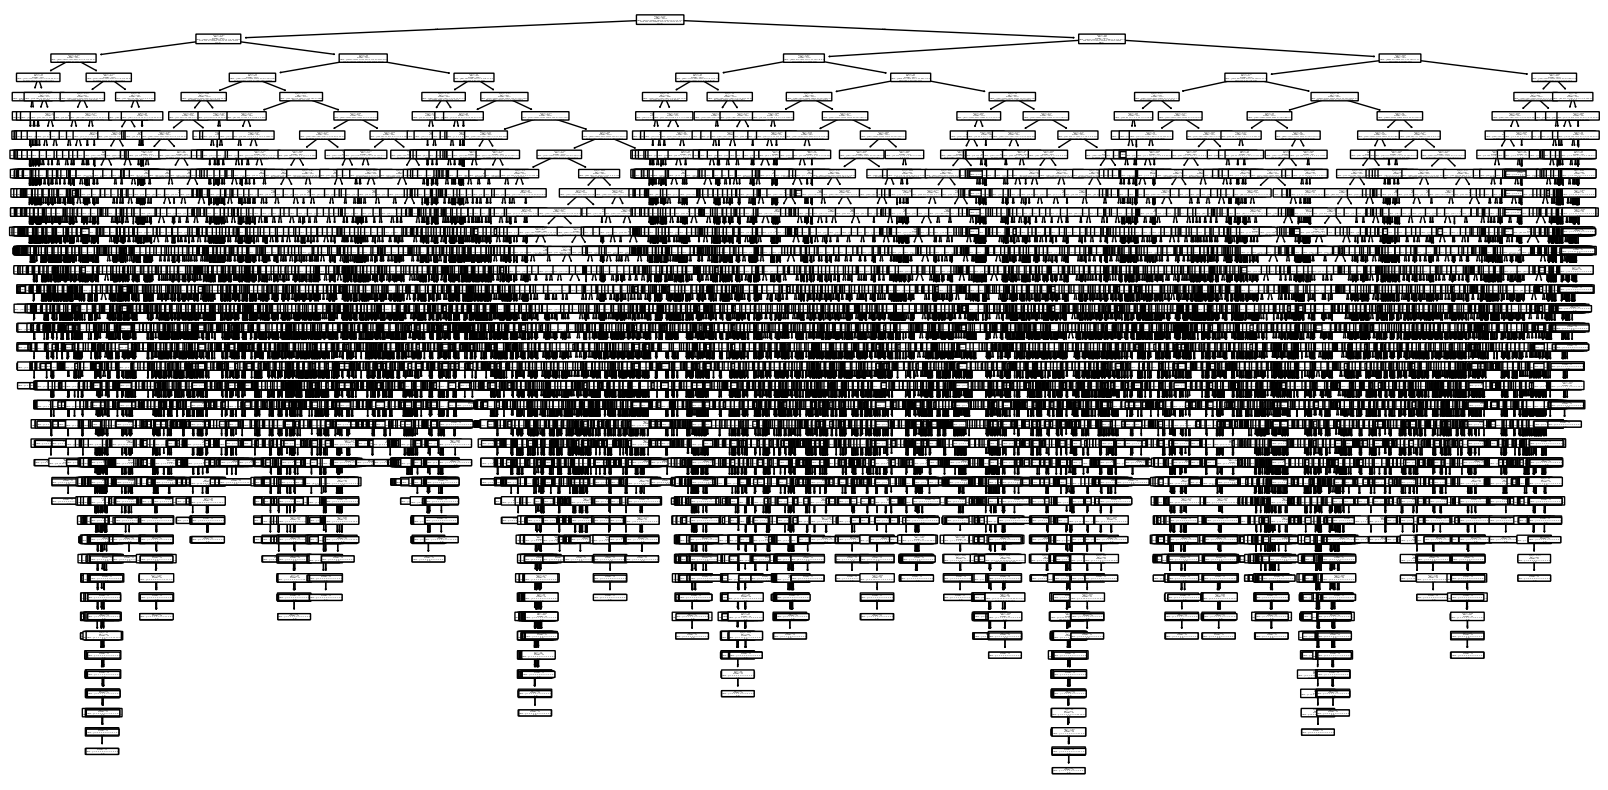

In [91]:
# print the tree map
best_tree = joblib.load("decision_tree_model.pkl").best_estimator_
plt.figure(figsize=(20,10))
plot_tree(best_tree,
          rounded=True,
          fontsize=1)
plt.show()

## Random Forest Model

Random Forest model for Pitch Type

In [24]:
# run the random forest model
rfclassifier = RandomForestClassifier(random_state=6740)
param_grid_rf = {
    'max_depth': [5, 10, 20],
    'n_estimators': [20, 30, 50],
    'max_features': ['sqrt', 'log2', 1]
}
grid_rf = GridSearchCV(estimator=rfclassifier, param_grid=param_grid_rf, scoring='f1_weighted', cv=3, verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=20; total time=   2.8s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=20; total time=   2.4s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=20; total time=   2.5s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=30; total time=   3.5s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=30; total time=   4.2s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=30; total time=   3.4s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=50; total time=   5.3s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=50; total time=   5.4s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=50; total time=   5.3s
[CV] END ....max_depth=5, max_features=log2, n_estimators=20; total time=   1.9s
[CV] END ....max_depth=5, max_features=log2, n_estimators=20; total time=   1.9s
[CV] END ....max_depth=5, max_features=log2, n_e

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=6740),
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2', 1],
                         'n_estimators': [20, 30, 50]},
             scoring='f1_weighted', verbose=2)

Random Forest model for Pitch Category

In [22]:
# run the random forest model
rfclassifier_cat = RandomForestClassifier(random_state=6740)
param_grid_rf_cat = {
    'max_depth': [5, 10, 20],
    'n_estimators': [20, 30, 50],
    'max_features': ['sqrt', 'log2', 1]
}
grid_rf_cat = GridSearchCV(estimator=rfclassifier_cat, param_grid=param_grid_rf_cat, scoring='f1_weighted', cv=3, verbose=2)
grid_rf_cat.fit(X_train, y_train_cat)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=20; total time=   3.0s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=20; total time=   2.7s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=20; total time=   2.8s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=30; total time=   3.6s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=30; total time=   3.5s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=30; total time=   5.2s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=50; total time=   5.4s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=50; total time=   5.2s
[CV] END ....max_depth=5, max_features=sqrt, n_estimators=50; total time=   5.5s
[CV] END ....max_depth=5, max_features=log2, n_estimators=20; total time=   2.1s
[CV] END ....max_depth=5, max_features=log2, n_estimators=20; total time=   2.0s
[CV] END ....max_depth=5, max_features=log2, n_e

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=6740),
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2', 1],
                         'n_estimators': [20, 30, 50]},
             scoring='f1_weighted', verbose=2)

In [25]:
joblib.dump(grid_rf, "random_forest_model2.pkl")

['random_forest_model2.pkl']

In [26]:
joblib.dump(grid_rf_cat, "random_forest_pitch_category.pkl")

['random_forest_pitch_category.pkl']

Results for Pitch Type

In [15]:
# load and print the best model estimators
best_rf = joblib.load("random_forest_model2.pkl").best_estimator_
print(joblib.load("random_forest_model2.pkl").best_params_)

# print the auc per class
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = best_rf.predict_proba(X_test_standardized)
# review the roc_auc per class
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
print(f"Macro-averaged ROC AUC: {roc_auc:.2f}")
# Calculate ROC AUC for each class separately
for i in range(len(np.unique(y))):
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
    print(f"ROC AUC for class {i}: {roc_auc:.2f}")

# print the accuracy per class
rf_pred = best_rf.predict(X_test)
rf_pitch_type = classification_report(y_test, rf_pred, output_dict=True)
print(classification_report(y_test, rf_pred))

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50}
Macro-averaged ROC AUC: 0.91
ROC AUC for class 0: 0.79
ROC AUC for class 1: 0.89
ROC AUC for class 2: 0.93
ROC AUC for class 3: 0.91
ROC AUC for class 4: 0.98
ROC AUC for class 5: 0.88
ROC AUC for class 6: 0.87
ROC AUC for class 7: 0.97
ROC AUC for class 8: 0.94
                 precision    recall  f1-score   support

4-Seam Fastball       0.53      0.70      0.60     26237
       Changeup       0.48      0.34      0.40      8481
      Curveball       0.51      0.33      0.40      5183
         Cutter       0.45      0.38      0.41      6883
  Knuckle Curve       0.51      0.32      0.39      1436
         Sinker       0.51      0.54      0.52     13239
         Slider       0.49      0.43      0.46     12624
   Split-Finger       0.48      0.36      0.41      2752
        Sweeper       0.50      0.41      0.45      5693

       accuracy                           0.51     82528
      macro avg       0.50      0.42      0.45

Results for Pitch Category

In [16]:
# load and print the best model estimators
best_rf_cat = joblib.load("random_forest_pitch_category.pkl").best_estimator_
print(joblib.load("random_forest_pitch_category.pkl").best_params_)

# print the auc per class
y_test_cat_bin = label_binarize(y_test_cat, classes=np.unique(y_category))
y_pred_cat_proba = best_rf_cat.predict_proba(X_test_standardized)
# review the roc_auc per class
roc_auc_cat = roc_auc_score(y_test_cat_bin, y_pred_cat_proba, multi_class='ovr', average='macro')
print(f"Macro-averaged ROC AUC: {roc_auc_cat:.2f}")
# Calculate ROC AUC for each class separately
for i in range(len(np.unique(y_category))):
    roc_auc_cat = roc_auc_score(y_test_cat_bin[:, i], y_pred_cat_proba[:, i])
    print(f"ROC AUC for class {i}: {roc_auc_cat:.2f}")

# print the accuracy per class
rf_cat_pred = best_rf_cat.predict(X_test)
rf_pitch_cat = classification_report(y_test_cat, rf_cat_pred, output_dict=True)
print(classification_report(y_test_cat, rf_cat_pred))

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50}
Macro-averaged ROC AUC: 0.75
ROC AUC for class 0: 0.84
ROC AUC for class 1: 0.69
ROC AUC for class 2: 0.73
              precision    recall  f1-score   support

    changeup       0.53      0.18      0.27     11233
    fastball       0.62      0.86      0.72     46359
    offspeed       0.54      0.31      0.40     24936

    accuracy                           0.60     82528
   macro avg       0.56      0.45      0.46     82528
weighted avg       0.58      0.60      0.56     82528



## AdaBoost

AdaBoost model for Pitch Type

In [37]:
abclassifier = AdaBoostClassifier(random_state=6740)

param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

grid_ab = GridSearchCV(estimator=abclassifier, param_grid=param_grid_ab, scoring='f1_weighted', cv=3, verbose=2)
grid_ab.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................learning_rate=0.1, n_estimators=50; total time=  34.1s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=  35.0s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=  30.5s
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 1.0min
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  57.6s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  55.7s
[CV] END ................learning_rate=0.1, n_estimators=200; total time= 1.8min
[CV] END ................learning_rate=0.1, n_estimators=200; total time= 1.8min
[CV] END ................learning_rate=0.1, n_estimators=200; total time= 2.0min
[CV] END .................learning_rate=0.5, n_estimators=50; total time=  33.5s
[CV] END .................learning_rate=0.5, n_estimators=50; total time=  29.4s
[CV] END .................learning_rate=0.5, n_es

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=6740),
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_weighted', verbose=2)

AdaBoost model for Pitch Category

In [39]:
abclassifier_cat = AdaBoostClassifier(random_state=6740)
param_grid_ab_cat = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}
grid_ab_cat = GridSearchCV(estimator=abclassifier_cat, param_grid=param_grid_ab_cat, scoring='f1_weighted', cv=3, verbose=2)
grid_ab_cat.fit(X_train, y_train_cat)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................learning_rate=0.1, n_estimators=50; total time= 1.3min
[CV] END .................learning_rate=0.1, n_estimators=50; total time= 1.3min
[CV] END .................learning_rate=0.1, n_estimators=50; total time= 1.1min
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.2min
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.5min
[CV] END ................learning_rate=0.1, n_estimators=100; total time= 2.2min
[CV] END ................learning_rate=0.1, n_estimators=200; total time= 4.4min
[CV] END ................learning_rate=0.1, n_estimators=200; total time= 4.2min
[CV] END ................learning_rate=0.1, n_estimators=200; total time= 3.9min
[CV] END .................learning_rate=0.5, n_estimators=50; total time=  58.8s
[CV] END .................learning_rate=0.5, n_estimators=50; total time=  56.8s
[CV] END .................learning_rate=0.5, n_es

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=6740),
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_weighted', verbose=2)

In [38]:
joblib.dump(grid_ab, "AdaBoost_model.pkl")

['AdaBoost_model.pkl']

In [40]:
joblib.dump(grid_ab_cat, "AdaBoost_pitch_category.pkl")

['AdaBoost_pitch_category.pkl']

Results for Pitch Type

In [26]:
best_ab = joblib.load("AdaBoost_model.pkl").best_estimator_
print(joblib.load("AdaBoost_model.pkl").best_params_)

ab_pred = best_ab.predict(X_test)
ab_pitch_type = classification_report(y_test, ab_pred, output_dict=True)
print(classification_report(y_test, ab_pred))

{'learning_rate': 1.0, 'n_estimators': 200}


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

                 precision    recall  f1-score   support

4-Seam Fastball       0.41      0.39      0.40     26238
       Changeup       0.23      0.09      0.13      8481
      Curveball       0.18      0.20      0.19      5183
         Cutter       0.25      0.23      0.24      6887
  Knuckle Curve       0.00      0.00      0.00      1436
         Sinker       0.38      0.51      0.43     13238
         Slider       0.31      0.39      0.35     12620
   Split-Finger       0.20      0.05      0.08      2752
        Sweeper       0.25      0.34      0.29      5693

       accuracy                           0.33     82528
      macro avg       0.25      0.25      0.24     82528
   weighted avg       0.32      0.33      0.32     82528



/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results for Pitch Category

In [25]:
best_ab_cat = joblib.load("AdaBoost_pitch_category.pkl").best_estimator_
print(joblib.load("AdaBoost_pitch_category.pkl").best_params_)

ab_cat_pred = best_ab_cat.predict(X_test)
ab_pitch_cat = classification_report(y_test_cat, ab_cat_pred, output_dict=True)
print(classification_report(y_test_cat, ab_cat_pred))

{'learning_rate': 1.0, 'n_estimators': 200}
              precision    recall  f1-score   support

    changeup       0.40      0.11      0.18     11233
    fastball       0.59      0.87      0.70     46363
    offspeed       0.49      0.21      0.29     24932

    accuracy                           0.57     82528
   macro avg       0.49      0.40      0.39     82528
weighted avg       0.53      0.57      0.50     82528



## K-nearest Neighbors

K-nearest Neighbor model for Pitch Type

In [34]:
pipe_knn = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': [3, 5],
    'pca__n_components': [.7, .8, .9]
}

grid_knn = GridSearchCV(pipe_knn, param_grid=param_grid_knn, cv=3, verbose=2)
grid_knn.fit(X_train_standardized, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ..........knn__n_neighbors=3, pca__n_components=0.7; total time=  20.7s
[CV] END ..........knn__n_neighbors=3, pca__n_components=0.7; total time=  17.8s
[CV] END ..........knn__n_neighbors=3, pca__n_components=0.7; total time=  18.8s
[CV] END ..........knn__n_neighbors=3, pca__n_components=0.8; total time=  23.8s
[CV] END ..........knn__n_neighbors=3, pca__n_components=0.8; total time=  19.8s
[CV] END ..........knn__n_neighbors=3, pca__n_components=0.8; total time=  23.7s
[CV] END ..........knn__n_neighbors=3, pca__n_components=0.9; total time=  26.6s
[CV] END ..........knn__n_neighbors=3, pca__n_components=0.9; total time=  23.8s
[CV] END ..........knn__n_neighbors=3, pca__n_components=0.9; total time=  31.6s
[CV] END ..........knn__n_neighbors=5, pca__n_components=0.7; total time=  18.0s
[CV] END ..........knn__n_neighbors=5, pca__n_components=0.7; total time=  17.0s
[CV] END ..........knn__n_neighbors=5, pca__n_com

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5],
                         'pca__n_components': [0.7, 0.8, 0.9]},
             verbose=2)

K-nearest Neighbor model for Pitch Category

In [ ]:
pipe_knn_cat = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': [3, 5],
    'pca__n_components': [.7, .8, .9]
}

grid_knn_cat = GridSearchCV(pipe_knn_cat, param_grid=param_grid_knn, cv=3, verbose=1)
grid_knn_cat.fit(X_train_standardized, y_train_cat)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5],
                         'pca__n_components': [0.7, 0.8, 0.9]},
             verbose=1)

In [35]:
joblib.dump(grid_knn, "KNN_model2.pkl")

['KNN_model2.pkl']

In [32]:
joblib.dump(grid_knn_cat, "KNN_pitch_category.pkl")

['KNN_pitch_category.pkl']

Results for Pitch Type

In [27]:
best_knn = joblib.load("KNN_model2.pkl").best_estimator_
print(joblib.load("KNN_model2.pkl").best_params_)

knn_pred = best_knn.predict(X_test_standardized)
knn_pitch_type = classification_report(y_test, knn_pred, output_dict=True)
print(classification_report(y_test, knn_pred))

{'knn__n_neighbors': 5, 'pca__n_components': 0.9}
                 precision    recall  f1-score   support

4-Seam Fastball       0.45      0.62      0.52     26238
       Changeup       0.29      0.26      0.28      8481
      Curveball       0.28      0.20      0.23      5183
         Cutter       0.35      0.31      0.33      6887
  Knuckle Curve       0.33      0.22      0.27      1436
         Sinker       0.43      0.41      0.42     13238
         Slider       0.39      0.30      0.34     12620
   Split-Finger       0.37      0.25      0.30      2752
        Sweeper       0.38      0.24      0.30      5693

       accuracy                           0.40     82528
      macro avg       0.36      0.31      0.33     82528
   weighted avg       0.39      0.40      0.39     82528



Results for Pitch Category

In [28]:
best_knn_cat = joblib.load("KNN_pitch_category.pkl").best_estimator_
print(joblib.load("KNN_pitch_category.pkl").best_params_)

knn_cat_pred = best_knn_cat.predict(X_test_standardized)
knn_pitch_cat = classification_report(y_test_cat, knn_cat_pred, output_dict=True)
print(classification_report(y_test_cat, knn_cat_pred))

{'knn__n_neighbors': 5, 'pca__n_components': 0.9}
              precision    recall  f1-score   support

    changeup       0.31      0.29      0.30     11233
    fastball       0.60      0.70      0.65     46363
    offspeed       0.44      0.32      0.37     24932

    accuracy                           0.53     82528
   macro avg       0.45      0.44      0.44     82528
weighted avg       0.51      0.53      0.52     82528



## Neural Network

Neural Network for Pitch Type

In [31]:
# set up neural network model
nn_model = MLPClassifier(max_iter=200, random_state=42)

# set up parameter grid
param_grid = {
    'hidden_layer_sizes': [(64,), (64, 64)],
    'activation': ['relu'], #'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001]#,  # L2 penalty
    # 'classifier__learning_rate_init': [0.001, 0.01],
    # 'classifier__batch_size': [32, 64]
}

# set up gridsearch
grid_nn = GridSearchCV(
    nn_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2
)

# fit the model
grid_nn.fit(X_train_standardized, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; total time= 3.5min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; total time= 3.8min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; total time= 3.8min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 64), solver=adam; total time= 6.2min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 64), solver=adam; total time= 6.2min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 64), solver=adam; total time= 6.2min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), solver=adam; total time=401.5min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), solver=adam; total time= 3.7min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), solver=adam; total time=50.0min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 64), solver=adam; total time= 5.4min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 64), solver=adam; total time= 5.9min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 64), solver=adam; total time= 4.9min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['relu'], 'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(64,), (64, 64)],
                         'solver': ['adam']},
             scoring='accuracy', verbose=2)

Neural Network for Pitch Category

In [34]:
# set up neural network model
nn_model_cat = MLPClassifier(max_iter=200, random_state=42)

# set up parameter grid
param_grid_cat = {
    'hidden_layer_sizes': [(64,), (64, 64)],
    'activation': ['relu'], #'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001]#,  # L2 penalty
    # 'classifier__learning_rate_init': [0.001, 0.01],
    # 'classifier__batch_size': [32, 64]
}

# set up gridsearch
grid_nn_cat = GridSearchCV(
    nn_model_cat,
    param_grid=param_grid_cat,
    cv=3,
    scoring='accuracy',
    verbose=2
)

# fit the model
grid_nn_cat.fit(X_train_standardized, y_train_cat)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; total time= 5.2min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; total time= 3.5min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; total time= 3.8min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 64), solver=adam; total time= 5.5min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 64), solver=adam; total time= 7.1min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 64), solver=adam; total time= 5.3min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), solver=adam; total time= 4.1min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), solver=adam; total time= 4.1min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64,), solver=adam; total time= 7.0min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 64), solver=adam; total time= 6.5min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 64), solver=adam; total time= 6.7min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 64), solver=adam; total time=10.5min


/home/jordan/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['relu'], 'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(64,), (64, 64)],
                         'solver': ['adam']},
             scoring='accuracy', verbose=2)

In [32]:
joblib.dump(grid_nn, "NN_model.pkl")

['NN_model.pkl']

In [36]:
joblib.dump(grid_nn_cat, "NN_pitch_category.pkl")

['NN_pitch_category.pkl']

Results for Pitch Type

In [29]:
best_nn = joblib.load("NN_model.pkl").best_estimator_
print(joblib.load("NN_model.pkl").best_params_)

nn_pred = best_nn.predict(X_test_standardized)
nn_pitch_type = classification_report(y_test, nn_pred, output_dict=True)
print(classification_report(y_test, nn_pred))

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 64), 'solver': 'adam'}
                 precision    recall  f1-score   support

4-Seam Fastball       0.58      0.68      0.63     26238
       Changeup       0.53      0.49      0.51      8481
      Curveball       0.56      0.52      0.54      5183
         Cutter       0.52      0.46      0.49      6887
  Knuckle Curve       0.58      0.49      0.53      1436
         Sinker       0.54      0.56      0.55     13238
         Slider       0.54      0.44      0.49     12620
   Split-Finger       0.51      0.55      0.53      2752
        Sweeper       0.56      0.47      0.51      5693

       accuracy                           0.56     82528
      macro avg       0.55      0.52      0.53     82528
   weighted avg       0.55      0.56      0.55     82528



Results for Pitch Category

In [30]:
best_nn_cat = joblib.load("NN_pitch_category.pkl").best_estimator_
print(joblib.load("NN_pitch_category.pkl").best_params_)

nn_cat_pred = best_nn_cat.predict(X_test_standardized)
nn_pitch_cat = classification_report(y_test_cat, nn_cat_pred, output_dict=True)
print(classification_report(y_test_cat, nn_cat_pred))

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 64), 'solver': 'adam'}
              precision    recall  f1-score   support

    changeup       0.59      0.42      0.49     11233
    fastball       0.70      0.80      0.75     46363
    offspeed       0.59      0.51      0.55     24932

    accuracy                           0.66     82528
   macro avg       0.63      0.58      0.60     82528
weighted avg       0.65      0.66      0.65     82528



In [ ]:
pitch_type_reports = {
    'LogisticRegression': lr_pitch_type,
    'DecisionTree': dt_pitch_type,
    'RandomForest': rf_pitch_type,
    'AdaBoost': ab_pitch_type,
    'KNN': knn_pitch_type,
    'NeuralNetwork': nn_pitch_type
}

pitch_cat_reports = {
    'LogisticRegression': lr_pitch_cat,
    'DecisionTree': dt_pitch_cat,
    'RandomForest': rf_pitch_cat,
    'AdaBoost': ab_pitch_cat,
    'KNN': knn_pitch_cat,
    'NeuralNetwork': nn_pitch_cat
}



print(pitch_type_reports)

{'LogisticRegression': {'4-Seam Fastball': {'precision': 0.46202106785087266, 'recall': 0.6820260690601417, 'f1-score': 0.5508696321379098, 'support': 26238.0}, 'Changeup': {'precision': 0.36622669180808715, 'recall': 0.20610777031010494, 'f1-score': 0.26376942809717824, 'support': 8481.0}, 'Curveball': {'precision': 0.3759664948453608, 'recall': 0.22515917422342271, 'f1-score': 0.281645951490286, 'support': 5183.0}, 'Cutter': {'precision': 0.41035120147874304, 'recall': 0.32234644983301874, 'f1-score': 0.3610636740668456, 'support': 6887.0}, 'Knuckle Curve': {'precision': 0.4306049822064057, 'recall': 0.2527855153203343, 'f1-score': 0.31856077226853885, 'support': 1436.0}, 'Sinker': {'precision': 0.4626081810784821, 'recall': 0.4724278591932316, 'f1-score': 0.46746645737564, 'support': 13238.0}, 'Slider': {'precision': 0.4441185394963083, 'recall': 0.34793977812995247, 'f1-score': 0.39018971875416536, 'support': 12620.0}, 'Split-Finger': {'precision': 0.40424456796361796, 'recall': 0.

In [ ]:
pitch_type_labels = ['4-Seam Fastball', 'Changeup', 'Curveball', 'Cutter', 'Knuckle Curve', 'Sinker', 'Slider', 'Split-Finger', 'Sweeper']
metrics = ['precision', 'recall', 'f1-score']
models = pitch_type_reports.keys()

print(pitch_type_labels)

model_metric_values = {}

for model in models:
    model_metric_values[model] = {}
    for metric in metrics:
        model_metric_values[model][metric] = []
        for pitch in pitch_type_labels:
            if pitch in pitch_type_reports[model] and isinstance(pitch_type_reports[model][pitch], dict):
                model_metric_values[model][metric].append(pitch_type_reports[model][pitch].get(metric, None))
            else:
                model_metric_values[model][metric].append(None)

print(model_metric_values)

['4-Seam Fastball', 'Changeup', 'Curveball', 'Cutter', 'Knuckle Curve', 'Sinker', 'Slider', 'Split-Finger', 'Sweeper']
{'LogisticRegression': {'precision': [0.46202106785087266, 0.36622669180808715, 0.3759664948453608, 0.41035120147874304, 0.4306049822064057, 0.4626081810784821, 0.4441185394963083, 0.40424456796361796, 0.41625788367203925], 'recall': [0.6820260690601417, 0.20610777031010494, 0.22515917422342271, 0.32234644983301874, 0.2527855153203343, 0.4724278591932316, 0.34793977812995247, 0.29069767441860467, 0.3130159845424205], 'f1-score': [0.5508696321379098, 0.26376942809717824, 0.281645951490286, 0.3610636740668456, 0.31856077226853885, 0.46746645737564, 0.39018971875416536, 0.33819488480236737, 0.35732905554441546]}, 'DecisionTree': {'precision': [0.5516467296042313, 0.5236146095717884, 0.5359790667248147, 0.4801183043049622, 0.5680868838763575, 0.526508505606835, 0.516641652688267, 0.48936170212765956, 0.5326271186440678], 'recall': [0.6837030261452854, 0.39217073458318596, 

In [64]:
pitch_cat_labels = ['fastball', 'changeup', 'offspeed']
metrics = ['precision', 'recall', 'f1-score']
models_cat = pitch_cat_reports.keys()

cat_model_metric_values = {}

for model in models_cat:
    cat_model_metric_values[model] = {}
    for metric in metrics:
        cat_model_metric_values[model][metric] = []
        for pitch in pitch_cat_labels:
            if pitch in pitch_cat_reports[model] and isinstance(pitch_cat_reports[model][pitch], dict):
                cat_model_metric_values[model][metric].append(pitch_cat_reports[model][pitch].get(metric, None))
            else:
                cat_model_metric_values[model][metric].append(None)

print(cat_model_metric_values)

{'LogisticRegression': {'precision': [0.7122208521715303, 0.2900402946802882, 0.4598616277856969], 'recall': [0.4485041951556198, 0.6343808421614885, 0.5305230226215306], 'f1-score': [0.5504043198030678, 0.3980783196469471, 0.49267157090976815]}, 'DecisionTree': {'precision': [0.6502907488986784, 0.505303351718286, 0.5371251403218047], 'recall': [0.7959795526605267, 0.3180806552123208, 0.4030162040750842], 'f1-score': [0.7157972321627729, 0.39040646853146854, 0.4605055111253695]}, 'RandomForest': {'precision': [0.6169941747572816, 0.5284720432878124, 0.5435818385650224], 'recall': [0.8566960722990316, 0.18258702038636163, 0.31116637253329055], 'f1-score': [0.7173508642019902, 0.271403996294826, 0.3957759412304867]}, 'AdaBoost': {'precision': [0.5864513130374157, 0.39961941008563273, 0.4864633798803078], 'recall': [0.8708668550352652, 0.11216950057865219, 0.20539868442162681], 'f1-score': [0.7009052955012977, 0.17517030446267204, 0.2888406328435658]}, 'KNN': {'precision': [0.60331144204

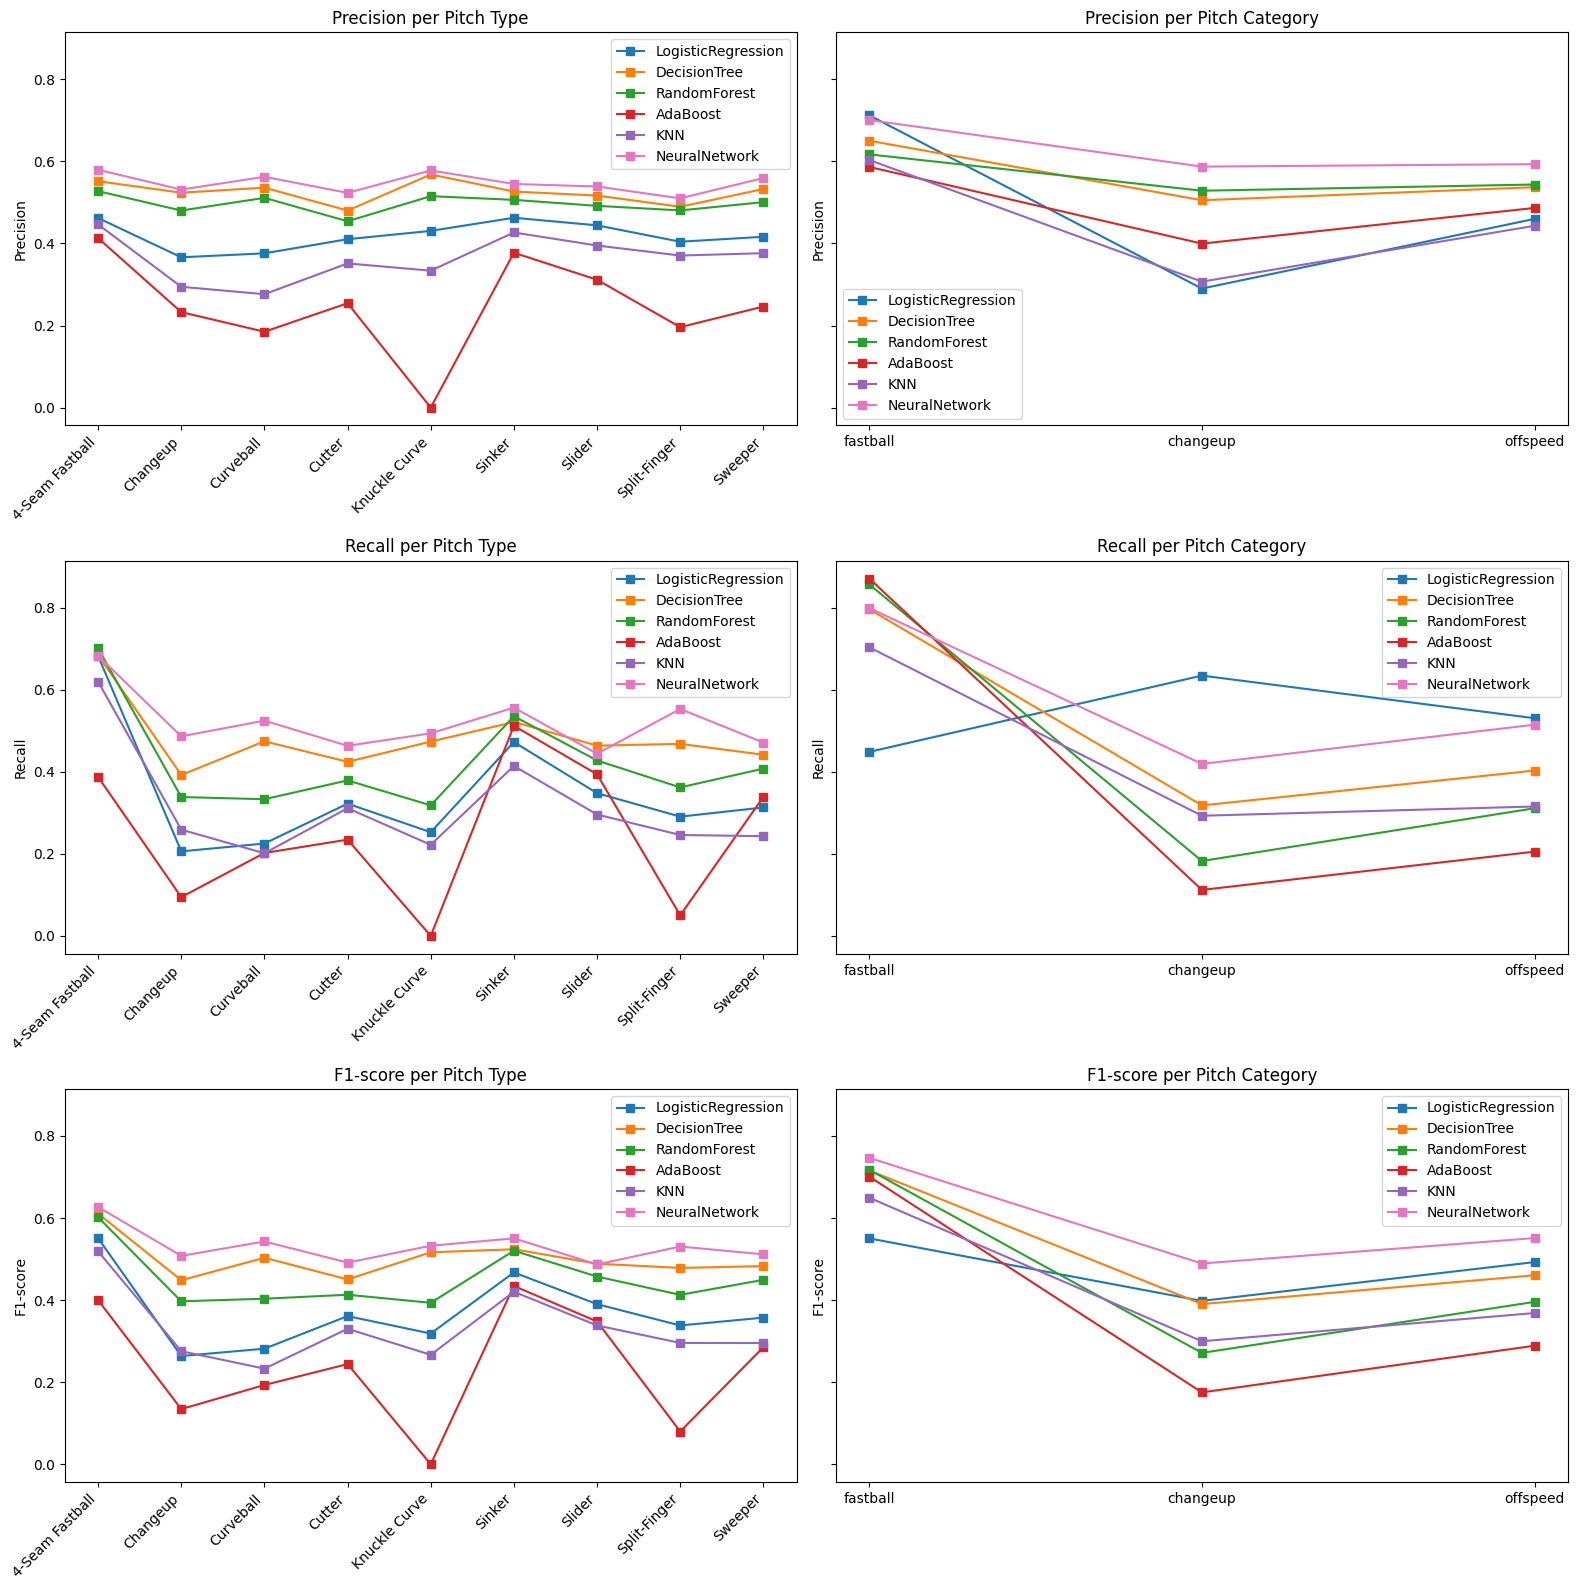

In [87]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), sharey=True)

for i, metric in enumerate(metrics):
    ax_type = axs[i, 0]
    x = np.arange(len(pitch_type_labels))

    for j, model in enumerate(models):
        scores =  model_metric_values[model][metric]
        ax_type.plot(pitch_type_labels, scores, label=model, marker='s', color=colors[j])
    
    ax_type.set_title(f'{metric.capitalize()} per Pitch Type')
    ax_type.set_xticks(x)
    ax_type.set_xticklabels(pitch_type_labels, rotation=45, ha='right')
    ax_type.set_ylabel(metric.capitalize())
    ax_type.legend()


    ax_cat = axs[i, 1]
    x = np.arange(len(pitch_cat_labels))

    for j, model in enumerate(models):
        scores =  cat_model_metric_values[model][metric]
        ax_cat.plot(pitch_cat_labels, scores, label=model, marker='s', color=colors[j])
    
    ax_cat.set_title(f'{metric.capitalize()} per Pitch Category')
    ax_cat.set_xticks(x)
    ax_cat.set_xticklabels(pitch_cat_labels)
    ax_cat.set_ylabel(metric.capitalize())
    ax_cat.legend()
    
    if i == 0:
        ax_cat.legend()

plt.tight_layout()
plt.show()
